 Background removing



### **Let's start!**

## 1. Preparation

# Installing Packages

In [6]:
#Install libraries
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install scikit-image
!pip install opencv-python
!pip install yacs
!pip install joblib
!pip install natsort
!pip install h5py
!pip install tqdm
!pip install einops
!pip install linformer
!pip install timm
!pip install ptflops
!pip install dataclasses

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
import collections.abc as container_abcs
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import math
import time
from torch import einsum

# Limpiamos la caché de CUDA
torch.cuda.empty_cache()

#import dependencies
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from io import BytesIO
# from urllib.request import urlopen
# from skimage.util import view_as_windows
# from scipy.fftpack import dctn, idctn
# from skimage.metrics import mean_squared_error
# %matplotlib inline


## 2. Upload Images and importing

In [9]:
import shutil
import os
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
    shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder)

# Upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
    shutil.move(image_name, os.path.join(input_folder, image_name))


Saving ruled_EX.jpg to ruled_EX.jpg


# Removing ruled line fuction

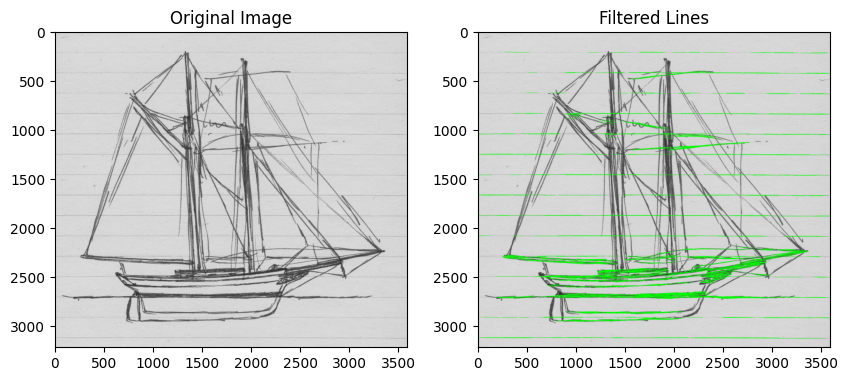

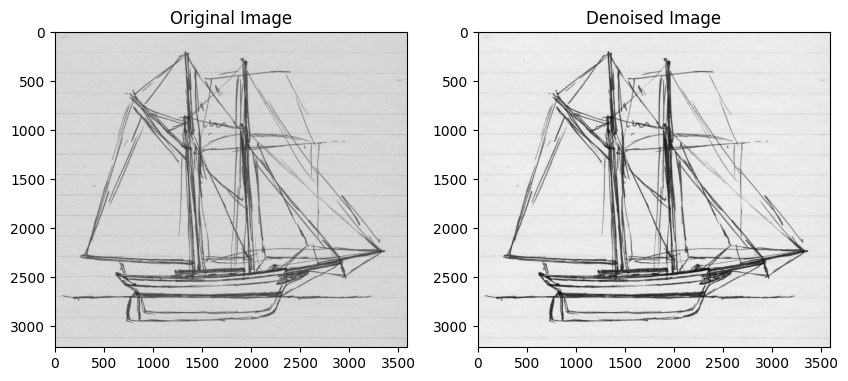

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


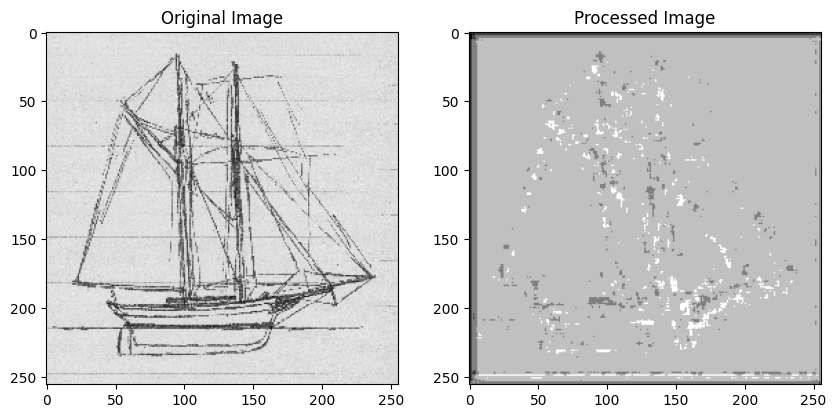

In [10]:
# Define U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(conv5)
    model = Model(inputs, outputs)
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess images
def load_image(path, target_size=(256, 256)):
    img = load_img(path, color_mode='grayscale', target_size=target_size)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Process each uploaded image
for image_name in image_names:
    image_path = os.path.join(input_folder, image_name)

    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply edge detection
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Filter lines based on orientation and length
    filtered_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Calculate the angle of the line
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                # Filter horizontal and vertical lines
                if (abs(angle) < 10 or abs(angle) > 170) and length > 100:
                    filtered_lines.append((x1, y1, x2, y2))

    # Draw filtered lines
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in filtered_lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Filtered Lines')
    plt.imshow(output_image)
    plt.show()

    # Apply Non-Local Means Denoising
    denoised_image = cv2.fastNlMeansDenoising(image, None, 30, 7, 21)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised_image, cmap='gray')
    plt.show()

    # Load and preprocess image for U-Net
    image_for_unet = load_image(image_path)
    prediction = model.predict(image_for_unet)

    # Save the processed image
    processed_image_path = os.path.join(output_folder, image_name)
    processed_image = (prediction[0, :, :, 0] * 255).astype(np.uint8)
    cv2.imwrite(processed_image_path, processed_image)

    # Display the original and processed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_for_unet[0, :, :, 0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_image, cmap='gray')
    plt.show()

<p align="justify">In the top menu of this session, select <b>Runtime -> Change runtime type</b>, and set <b>Hardware Accelerator</b> to <b>GPU</b>.</p>

<p align="justify">Clone the repository, and download the pre-trained model:</p>


In [ ]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 276 (delta 105), reused 252 (delta 98), pack-reused 0
Receiving objects: 100% (276/276), 60.77 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/MODNet
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 32.9MB/s]


<p align="justify">Upload portrait images to be processed (only PNG and JPG format are supported):</p>

## 3. Inference

<p align="justify">Run the following command for alpha matte prediction:</p>

In [ ]:

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: jcm.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


## 4. Visualization

<p align="justify">Display the results (from left to right: image, foreground, and alpha matte):</p>

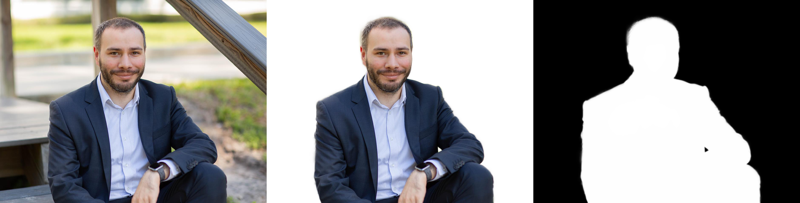

jcm.jpg 



In [ ]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


## Download Results

<p align="justify">Download the Zip package of predicted alpha mattes:</p>

In [ ]:
zip_filename = 'matte.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {output_folder}/*")
files.download(zip_filename)